Uses this dataset: https://www.kaggle.com/datasets/fareselmenshawii/face-detection-dataset 

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
from yunet import YuNet
import cv2
import os
from pathlib import Path

C:\Users\Kirina\anaconda3\envs\tensorflow-yolo\Lib\site-packages\requests\__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


In [2]:
_TRAIN_IMAGE_DIRECTORY = Path("../data/images/train/")
_TRAIN_LABEL_DIRECTORY = Path("../data/labels/train/")

In [3]:
def create_image_list(directory):
    for root, dirs, files in os.walk(directory):
        return files

train_images = create_image_list(_TRAIN_IMAGE_DIRECTORY)
print("Amount of train images: ", len(train_images))

Amount of train images:  13386


In [4]:
def parse_annotations_yolo(annotions_file_path, image_width, image_height):
    annotations = []
    with open(annotions_file_path, 'r') as file:
        for box_annotation in file:
            coordinates = box_annotation.strip().split()[1:]
            x_center, y_center, width, height = map(float, coordinates)
            x_min = int((x_center - width / 2) * image_width)
            y_min = int((y_center - height / 2) * image_height)
            x_max = int((x_center + width / 2) * image_width)
            y_max = int((y_center + height / 2) * image_height)
            annotations.append(((x_min, y_min), (x_max, y_max)))
    return annotations

### Plot some images with ground truth bounding boxes

In [5]:
images_to_show = train_images[:9]

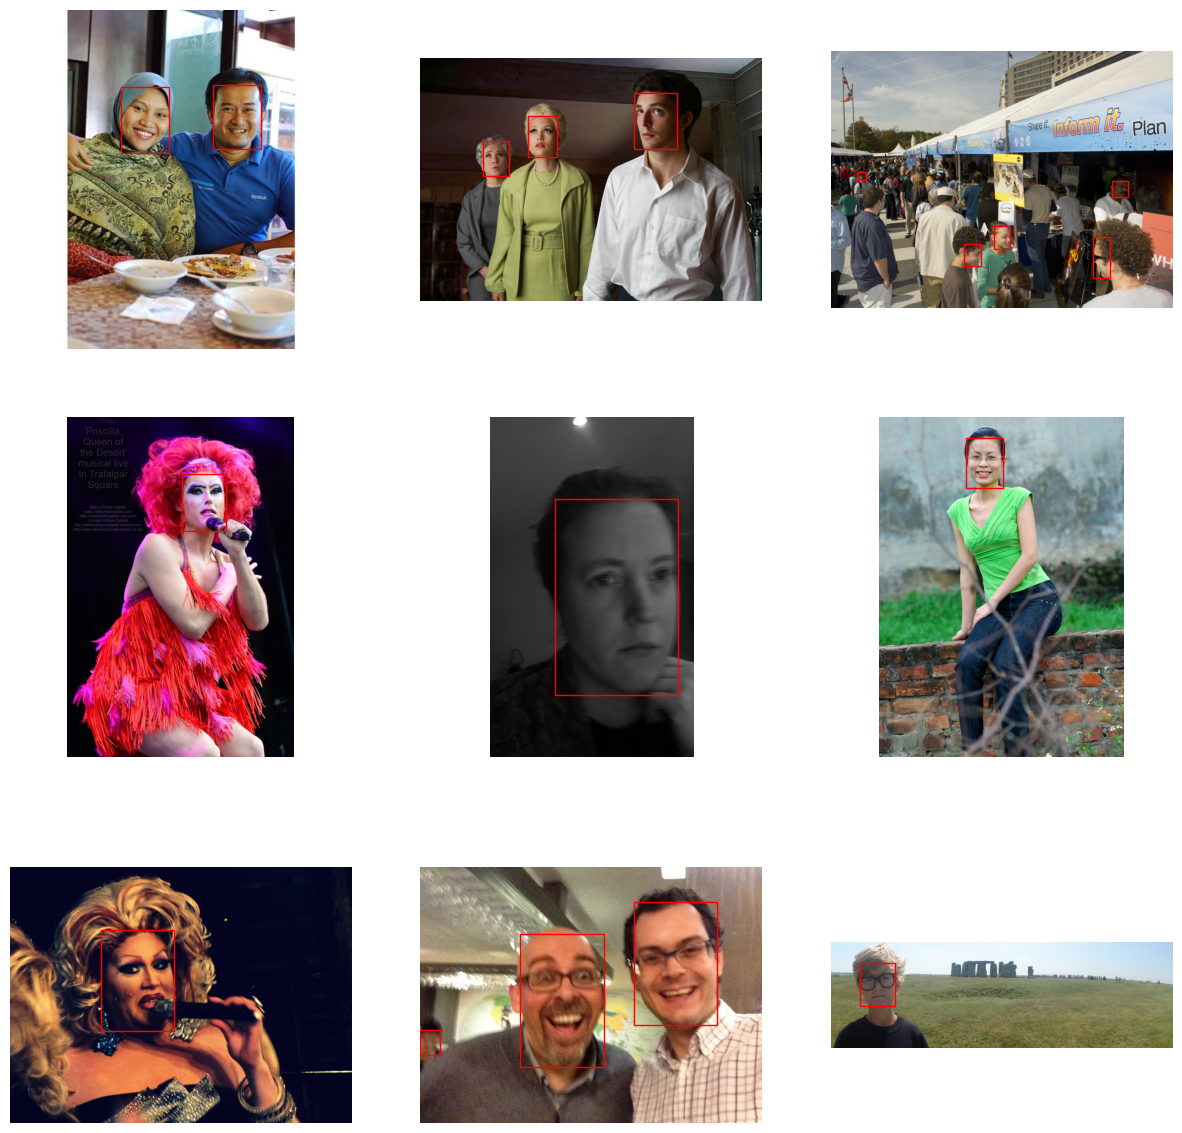

In [6]:
fig, axs = plt.subplots(3, 3, figsize=(15, 15))
axs = axs.flatten()

for ax, image_path in zip(axs, images_to_show):
    image_path = Path(image_path)
    image = cv2.imread(_TRAIN_IMAGE_DIRECTORY/image_path)
    b,g,r = cv2.split(image) # opencv uses BGR instead of RGB
    image = cv2.merge([r,g,b]) 
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image_height, image_width, = gray_image.shape
    
    annotations = parse_annotations_yolo(_TRAIN_LABEL_DIRECTORY/image_path.with_suffix(".txt"), 
                                         image_width, image_height)
    ax.imshow(image)
    for ((x_min, y_min), (x_max, y_max)) in annotations:
        bounding_box = plt.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(bounding_box)
    ax.axis('off')
plt.show()

### Let's try out a face detection model that uses haarcascades

Haar cascades are a machine learning algorithm that use the difference in brightness between the regions in an image to detect objects. 

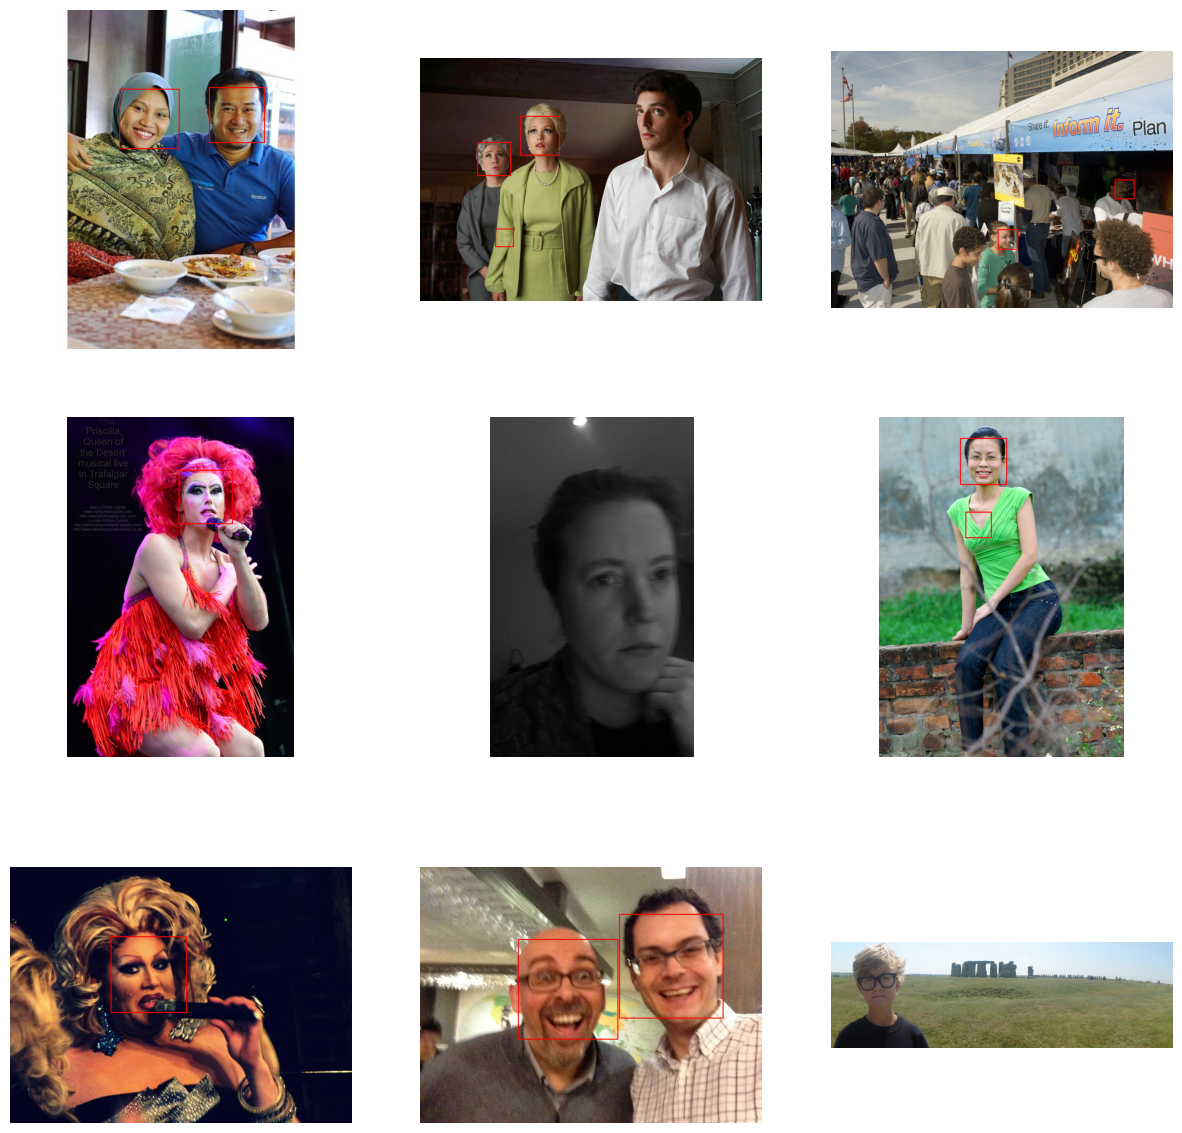

In [7]:
fig, axs = plt.subplots(3, 3, figsize=(15, 15))
axs = axs.flatten()
face_classifier = cv2.CascadeClassifier(
    cv2.data.haarcascades + "haarcascade_frontalface_default.xml"
)
# face_classifier = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_profileface.xml')

for ax, image_path in zip(axs, images_to_show):
    image_path = Path(image_path)
    image = cv2.imread(_TRAIN_IMAGE_DIRECTORY/image_path)
    b,g,r = cv2.split(image) # opencv uses BGR instead of RGB
    image = cv2.merge([r,g,b]) 
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    face = face_classifier.detectMultiScale(
        gray_image, scaleFactor=1.2, minNeighbors=5, minSize=(40, 40)
    )
    
    for (x_min, y_min, width, height) in face:
        cv2.rectangle(image, (x_min, y_min), (x_min + width, y_min + height), (255, 0, 0), 2)

    
    ax.imshow(image)
    ax.axis('off')
plt.show()

### Oh no! a lot of the faces are not detected and there are some lonely boxes wihtout a face floating around!

A problem with haar cascades is that they can only work from very select angles. Link in this example, the haar cascade can only detect images that are directly facing the camera. Side profiles or faces cannot be detected. Faces that have a different contrast than expected, for example due to poor lighting or due to strong glasses also cannot be detected. 


### Let's try a different model that is more sophisticated and see how it performes on our data

In [ ]:
fig, axs = plt.subplots(3, 3, figsize=(15, 15))
axs = axs.flatten()

model = YuNet(modelPath='../data/face_detection_yunet_2023mar.onnx')
for ax, image_path in zip(axs, images_to_show):
    image = cv2.imread(_TRAIN_IMAGE_DIRECTORY/image_path)
    b,g,r = cv2.split(image) # opencv uses BGR instead of RGB
    image = cv2.merge([r,g,b])
    
    
    image_height, image_width, _ = image.shape
    model.setInputSize([image_width, image_height])
    
    results = model.infer(image)

    for detection in results:
        x_min, y_min, width, height = map(int, detection[:4])
        cv2.rectangle(image, (x_min, y_min), (x_min + width, y_min + height), (255, 0, 0), 2)
    ax.imshow(image)
    ax.axis('off')
plt.show()

### That looks a lot better!